# Coordinate Ascent Variational Inference on Probabilistic Count Matrix Factorization

Note: when N != P, there is an identifiability issue if alpha_k2 goes to zero or beta_k2 goes to infinity or vice-versa.

In [5]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import utils, inference

from ZIFA import ZIFA

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from scipy.stats import gamma

plt.style.use('ggplot')

## Data generation

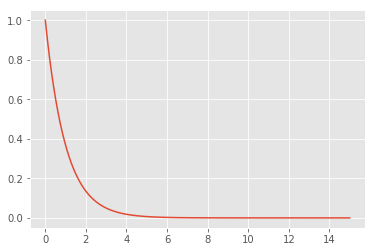

In [2]:
# Decide the prior parameters for U generation
a = 1.
b = 1.

x = np.linspace(0, 15, 1000)

prior_pdf = gamma.pdf(x, a, scale=1./b) 
plt.plot(x, prior_pdf)
plt.show()

In [8]:
# Experiment parameters
N = 100 # number of observations
P = 2 # observation space dimensionality
K = 2 # latent space dimensionality
C = 2 # number of clusters

z_p_arr = [0., 0.3, 0.6] # none, low, high ZI
eps_arr = [2., 10.] # low, high separability
n_runs = 1 # number of experiments per setting

zi_debug_strs = ['NO zero-inflation', 'LOW zero-inflation', 'HIGH zero-inflation']
eps_debug_strs = ['LOW separability', 'HIGH separability']

pca_scores = np.zeros((len(z_p_arr), len(eps_arr), n_runs))
zifa_scores = np.zeros((len(z_p_arr), len(eps_arr), n_runs))
pcmf_scores = np.zeros((len(z_p_arr), len(eps_arr), n_runs))

for i in range(len(z_p_arr)):
    print('%s:' % zi_debug_strs[i])
    for j in range(len(eps_arr)):
        print('\t%s' % eps_debug_strs[j])
        for k in range(n_runs):
            # Generate data set
            Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p_arr[i], 
                                                             eps=eps_arr[j], return_all=True)
            log_Y = np.log(1 + Y)

            # Run ZIFA
            zifa, model_params = ZIFA.fitModel(log_Y, K, test_input=False, verbose=False)

            # Run PCA
            pca = PCA(n_components=2).fit_transform(Y)

            # Run CAVI and get estimates (pCMF)
            alpha = np.ones((2, K))
            alpha[0, :] = 3.
            alpha[1, :] = 0.5
            beta = np.ones((2, P, K))
            pi = np.ones((P,)) * 0.5
            cavi = inference.Inference(Y, alpha, beta, pi)
            cavi.run_cavi(n_iterations=200, return_elbo=False, verbose=False)
            est_U = cavi.a[0] / cavi.a[1]

            # Calculate silhouette scores method
            zifa_silh = silhouette_score(zifa, clusters)
            pcmf_silh = silhouette_score(est_U, clusters)
            pca_silh = silhouette_score(pca, clusters)

            # Store scores in array
            pca_scores[i, j, k] = pca_silh
            zifa_scores[i, j, k] = zifa_silh
            pcmf_scores[i, j, k] = pcmf_silh
    print('')

# Prepare arrays to plot
low_sep_no_zi = [pca_scores[0, 0, :], zifa_scores[0, 0, :], pcmf_scores[0, 0, :]]
high_sep_no_zi = [pca_scores[0, 1, :], zifa_scores[0, 1, :], pcmf_scores[0, 1, :]]

low_sep_low_zi = [pca_scores[1, 0, :], zifa_scores[1, 0, :], pcmf_scores[1, 0, :]]
high_sep_low_zi = [pca_scores[1, 1, :], zifa_scores[1, 1, :], pcmf_scores[1, 1, :]]

low_sep_low_zi = [pca_scores[2, 0, :], zifa_scores[2, 0, :], pcmf_scores[2, 0, :]]
high_sep_low_zi = [pca_scores[2, 1, :], zifa_scores[2, 1, :], pcmf_scores[2, 1, :]]

  0%|          | 0/3 [00:00<?, ?it/s]

NO zero-inflation:
	LOW separability
	HIGH separability


 33%|███▎      | 1/3 [00:25<00:51, 25.80s/it]


LOW zero-inflation:
	LOW separability
	HIGH separability


 67%|██████▋   | 2/3 [00:50<00:25, 25.10s/it]


HIGH zero-inflation:
	LOW separability
	HIGH separability


100%|██████████| 3/3 [01:12<00:00, 24.22s/it]

In [ ]:
low_sep_no_zi = [pca_scores[0, 0, :], zifa_scores[0, 0, :], pcmf_scores[0, 0, :]]
high_sep_no_zi = [pca_scores[0, 1, :], zifa_scores[0, 1, :], pcmf_scores[0, 1, :]]

low_sep_low_zi = [pca_scores[1, 0, :], zifa_scores[1, 0, :], pcmf_scores[1, 0, :]]
high_sep_low_zi = [pca_scores[1, 1, :], zifa_scores[1, 1, :], pcmf_scores[1, 1, :]]

low_sep_low_zi = [pca_scores[2, 0, :], zifa_scores[2, 0, :], pcmf_scores[2, 0, :]]
high_sep_low_zi = [pca_scores[2, 1, :], zifa_scores[2, 1, :], pcmf_scores[2, 1, :]]

In [ ]:
# Plot data
legend=['PCA', 'ZIFA', 'pCMF']
fig = plt.figure(figsize=(15, 4))

ax1 = plt.subplot(1, 3, 1)
plot_simulation_results(low_sep_no_zi, high_sep_no_zi, ax=ax1, title='No ZI')

ax2 = plt.subplot(1, 3, 2)
plot_simulation_results(low_sep_low_zi, high_sep_low_zi, ax=ax2, title='Low ZI')

ax3 = plt.subplot(1, 3, 3)
_, handles = plot_simulation_results(low_sep_low_zi, high_sep_low_zi, ax=ax3, legend=legend, title='High ZI')

plt.legend(handles, legend, labelspacing=0.5, bbox_to_anchor=(1.3, 0.9))
_ = [h.set_visible(False) for h in handles]

plt.show()

In [ ]:
# Plot data
s = 30
alpha = 0.7

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(2, 2, 1)
handlers = []
for c in range(C):
    h = ax1.scatter(U[0, int(c*N/C):int((c+1)*N/C)], U[1, int(c*N/C):int((c+1)*N/C)], s=s, alpha=alpha)
    handlers.append(h)
ax1.legend(handlers, labels, scatterpoints=1)
plt.title('True $\mathbf{U}$')

ax2 = plt.subplot(2, 2, 2)
handlers = []
for c in range(C):
    h = ax2.scatter(est_U[int(c*N/C):int((c+1)*N/C), 0], est_U[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax2.legend(handlers, labels, scatterpoints=1)
plt.title('Mean estimated $\mathbf{U}$')

ax3 = plt.subplot(2, 2, 3)
handlers = []
for c in range(C):
    h = ax3.scatter(zifa[int(c*N/C):int((c+1)*N/C), 0], zifa[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax3.legend(handlers, labels, scatterpoints=1)
plt.title('ZIFA')

ax4 = plt.subplot(2, 2, 4)
handlers = []
for c in range(C):
    h = ax4.scatter(pca[int(c*N/C):int((c+1)*N/C), 0], pca[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax4.legend(handlers, labels, scatterpoints=1)
plt.title('PCA')

plt.show()